#クリーク問題
クリーク問題は、グラフ理論において、グラフ中のクリーク（任意の二頂点間に枝があるような頂点集合）を見つける問題。下記はグラフ中にKのクリークが存在するかどうかをみつけるコスト関数です。1項目は頂点数をKに制約する条件。2項目のBで囲まれた部分は選んだ頂点が完全グラフを構成している場合にコストがもっとも小さくなるようなエッジの数の条件です。クリーク数がKのものが存在する場合、コスト関数E=0となります。

$$E = \left( K - \sum_vx_v\right)^2 + B \left[ \frac{K(K-1)}{2} - \sum_{(u,v)\in E}x_ux_v\right]$$

##例題
下記のように6つのノードのネットワーク構造からクリーク数3を探します。

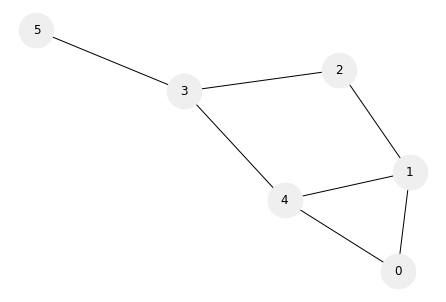

In [1]:
import networkx as nx
import matplotlib.pyplot as plt

options = {'node_color': '#efefef','node_size': 1200,'with_labels':'True'}

G = nx.Graph()
G.add_nodes_from(nx.path_graph(6))
G.add_edges_from([(0,1),(0,4),(1,2),(1,4),(2,3),(3,4),(3,5)])
nx.draw(G, **options)

今回はノード数が6なので、6量子ビット用意します。次に今回はクリーク数3ということで、上記の式のK=3とします。今回も少し工夫してみます。上記の式は、

$$E = \left( 3 - \sum_v x_v \right)^2 + B\left[ \frac{3(3-1)}{2} - \sum_{(u,v)\in E} x_u x_v\right]\\
= \left( 3 - \sum_{v=0}x_v \right)^2 + B (3-x_0x_4-x_0x_1-x_1x_4-x_1x_2-x_2x_3-x_3x_4-x_3x_5)$$

1項目と2項目を別々に構築して足し合わせてみます。1項目の方は$9-6A+A^2$という形に変形できますので、機能をうまく使って行列計算で処理できます。定数項は無視します。また、2項目は手作業で作ってしまいます。まずツールをインストールして準備します。また、numpyを使いますので、それも準備しておきます。

In [2]:
!pip install -U blueqat

     |████████████████████████████████| 51kB 3.9MB/s 


In [0]:
import blueqat.opt as wq
import numpy as np
a = wq.opt()

次に$x_0+x_1+x_2+x_3+x_4+x_5$の係数を見ると全て1なので、これを対角行列で用意します。

In [4]:
A = [1,1,1,1,1,1]
print(np.diag(A))

[[1 0 0 0 0 0]
 [0 1 0 0 0 0]
 [0 0 1 0 0 0]
 [0 0 0 1 0 0]
 [0 0 0 0 1 0]
 [0 0 0 0 0 1]]


そしてこのAを使って、1項目の$-6A+A^2$を簡単に計算してみます。

In [5]:
print(wq.sqr(A))

[[1 2 2 2 2 2]
 [0 1 2 2 2 2]
 [0 0 1 2 2 2]
 [0 0 0 1 2 2]
 [0 0 0 0 1 2]
 [0 0 0 0 0 1]]


これらを足し合わせると最初の項になります。

In [6]:
matrix1 = -6*np.diag(A)+wq.sqr(A)
print(matrix1)

[[-5  2  2  2  2  2]
 [ 0 -5  2  2  2  2]
 [ 0  0 -5  2  2  2]
 [ 0  0  0 -5  2  2]
 [ 0  0  0  0 -5  2]
 [ 0  0  0  0  0 -5]]


次に2項目を手入力します。Bは0.8でやってみます。

In [7]:
B = 0.8
matrix2 = B*np.asarray([[0,-1,0,0,-1,0],[0,0,-1,0,-1,0],[0,0,0,-1,0,0],[0,0,0,0,-1,-1],[0,0,0,0,0,0],[0,0,0,0,0,0]])
print(matrix2)

[[ 0.  -0.8  0.   0.  -0.8  0. ]
 [ 0.   0.  -0.8  0.  -0.8  0. ]
 [ 0.   0.   0.  -0.8  0.   0. ]
 [ 0.   0.   0.   0.  -0.8 -0.8]
 [ 0.   0.   0.   0.   0.   0. ]
 [ 0.   0.   0.   0.   0.   0. ]]


最後にこれらを足し合わせて計算をします。

In [8]:
a.qubo = matrix1 + matrix2
print(a.qubo)
a.sa()

[[-5.   1.2  2.   2.   1.2  2. ]
 [ 0.  -5.   1.2  2.   1.2  2. ]
 [ 0.   0.  -5.   1.2  2.   2. ]
 [ 0.   0.   0.  -5.   1.2  1.2]
 [ 0.   0.   0.   0.  -5.   2. ]
 [ 0.   0.   0.   0.   0.  -5. ]]


[1, 1, 0, 0, 1, 0]

上記で実際に生成されたQUBO、実行時間、最終的な解が得られました。
上記からの1番目、2番目、5番目の量子ビットが1ですので、
クリーク数3は上記量子ビット間にあるということがQUBOで導きだせました。
念のため最終的に生成されたイジングマトリックスを確認するには、


In [9]:
print(a.J)

[[-0.4  0.3  0.5  0.5  0.3  0.5]
 [ 0.  -0.6  0.3  0.5  0.3  0.5]
 [ 0.   0.  -0.4  0.3  0.5  0.5]
 [ 0.   0.   0.  -0.6  0.3  0.3]
 [ 0.   0.   0.   0.  -0.6  0.5]
 [ 0.   0.   0.   0.   0.  -0.2]]


コスト関数の変遷も見てみます。

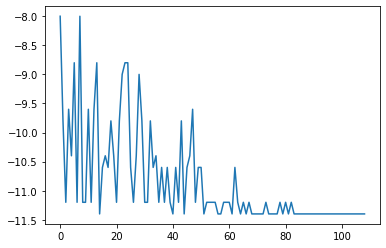

In [10]:
a.plot()

以上です。